In [51]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats

## Inserez les chemins vers le fichiers CSV:

In [52]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point') :
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)

['point35', 'point14_29_07_15', 'point15_29_07_15', '.DS_Store', 'schema_dispositif_AvAv_23_07_15.png', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18']
['35', '14', '15', '47', '13', '36', '46', '34', '48']


In [53]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [54]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = {}
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if (x.startswith('p') and x.endswith('.csv')) and not x.endswith('cleaned.csv') :
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    chemin_etalonnage = 'configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv'
    if os.path.exists(chemin_etalonnage):
        with open(chemin_etalonnage) as fichier :
            lignes = fichier.readlines()
            for l in lignes :
                if l.startswith('Intercept') :
                    dico['intercept'] = float(l[10:-2])
                if l.startswith('dU/dH') :
                    dico['dU/dH'] = float(l[6:-2])
                if l.startswith('dU/dT') :
                    dico['dU/dT'] = float(l[6:-2]) 
    data[dico['numero']] = dico


In [55]:
data['46']['pression']['Date Heure, GMT+01:00'].is_monotonic_increasing
#data[5]['numero']

False

In [56]:
# en faisant data[0] on a accès à toutes les informations du point 1
data['35']

{'numero': '35',
 'nom': 'point35',
 'date': '',
 'chemin': './raw_data/point35',
 'capteur': 'p508',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'temperature':      Date Heure, GMT+01:00  Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164)  \
 0     07/12/16 11:00:00 AM                                            22.154   
 1     07/12/16 11:15:00 AM                                            26.500   
 2     07/12/16 11:30:00 AM                                            14.553   
 3     07/12/16 11:45:00 AM                                            14.768   
 4     07/12/16 12:00:00 PM                                            15.031   
 ...                    ...                                               ...   
 2110  08/03/16 10:30:00 AM                                            14.409   
 2111  08/03/16 10:45:00 AM                                            17.819   
 2112  08/03/16 11:00:00 AM                                            19.318   
 2113  08/03/16

# Est ce que les fichiers peuvent être utilisés ?

**Dans notre cas, nous prendrons ces solutions**

* S'il manque toutes les données du capteurs de pression ou l'étalonnage, nous déciderons que ce point est invalide.
* S'il manque une partie des données nous vérifierons que nous avons au mimimun 7 jours de données
* S'il manque plus de 2 capteurs de température, nous déciderons que ce point est invalide.

### Est ce que nous avons les données de l'étalonnage du capteur ?

In [57]:
for x in data.values()  :
    if not 'intercept' in x.keys() :
        print('le point '+ x['numero'] + ' n\'a pas d\'étalonnage, il n\'est pas valide')
        data.remove(x)

### Est ce que nous avons des données pour le capteur de pression ?

In [58]:
for x in data.values() :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

In [59]:
data['35']['pression']

,"Date Heure, GMT+01:00","Tension, V (LGR S/N: 10445475, SEN S/N: 10445475, LBL: température)","Temp., °C (LGR S/N: 10445475, SEN S/N: 10445475, LBL: Température)"
0,07/12/16 12:00:00 PM,1.56471,20.007
1,07/12/16 12:15:00 PM,0.62210,14.361
2,07/12/16 12:30:00 PM,0.63614,14.314
3,07/12/16 12:45:00 PM,0.69780,14.218
4,07/12/16 01:00:00 PM,0.66911,14.098
...,...,...,...
2106,08/03/16 10:30:00 AM,2.49939,14.314
2107,08/03/16 10:45:00 AM,2.49939,17.558
2108,08/03/16 11:00:00 AM,2.49939,18.129
2109,08/03/16 11:06:59 AM,NaN,NaN


### On modifie les nom des colonnes du dataframe

In [60]:
# pour les températures
for x in data.values() :
    # on supprime les colonnes qui ne servent à rien
    for i in x['temperature'].columns :
        if not( i.startswith(('Date', 'dates', 'temp','Temp'))) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith(('Date', 'dates', 'Tension', 'tension', 'pressure', 'temp', 'Temp'))) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP
    

In [61]:
# notamment la température et la pression
data['14']['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/23/15 02:00:00 PM,26.207,27.554,26.378,28.097
1,07/23/15 02:15:00 PM,28.147,27.087,26.867,29.265
2,07/23/15 02:30:00 PM,28.419,28.543,27.431,29.615
3,07/23/15 02:45:00 PM,18.390,21.223,18.319,19.555
4,07/23/15 03:00:00 PM,18.509,21.318,18.461,19.413


## Conversion de valeurs de tension a differance de charge

In [62]:
for point in data.values():
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data['14']['pression']

,dates,tension,temperature_stream,dH
0,07/23/15 02:00:00 PM,0.01183,45.230,0.183945
1,07/23/15 02:15:00 PM,0.00080,21.979,0.104472
2,07/23/15 02:30:00 PM,0.00080,21.609,0.103194
3,07/23/15 02:45:00 PM,0.00092,21.910,0.104225
4,07/23/15 03:00:00 PM,0.00088,20.966,0.100966
...,...,...,...,...
558,07/29/15 09:30:00 AM,1.23991,15.562,-0.014592
559,07/29/15 09:45:00 AM,1.23709,15.541,-0.014444
560,07/29/15 10:00:00 AM,1.24273,15.513,-0.014982
561,07/29/15 10:15:00 AM,1.24022,15.599,-0.014488


### On enlève les valeurs Nan

In [63]:
for x in data.values() :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

In [64]:
from dateutil import parser

# Conversion dans le bon format date
for x in data.values():
    x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
    x['temperature']['dates'] = x['temperature']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
#    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='mixed')
#    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='mixed')

<ipython-input-64-561224788a7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))


In [97]:
for x in data.values():
    x['to_process'] = pd.merge(x['pression'], x['temperature'], on='dates', how='inner')

In [98]:
for x in data.values() :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_process = [col for col in x['to_process'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['processed'] = x['to_process'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_process :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['to_process'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['to_process'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['processed'][column_name] = df_cleaned[column_name]

In [99]:
for x in data.values() :
    x['processed'] = x['processed'].dropna(axis = 0, how = 'any')

In [100]:
# on met à jour la date de début de la mesure, la date de fin et la période
from datetime import datetime

for x in data.values() :
    x['dateDebut'] = datetime.strptime(x['processed']['dates'].iloc[0], '%d-%m-%Y %H:%M')
    x['dateFin'] = datetime.strptime(x['processed']['dates'].iloc[x['processed']['dates'].shape[0]-1], '%d-%m-%Y %H:%M')
    x['periode'] = x['dateFin'] - x['dateDebut']

### Est ce que nous avons au minimum 3 jours de données ?

In [101]:
for x in data.values() :
    if x['periode'].days <= 3 :
        print('le point ' + x['numero'] + ' n\'est pas valide car sa période est de seulement ' + str(x['periode'])[0] +' jours')
        #del data[x['numero']]

le point 15 n'est pas valide car sa période est de seulement 2 jours


### Création du fichier `info.txt`

In [70]:
# Ouvrez un fichier en mode écriture ('w')
for x in data.values() :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

In [102]:
data['34']['processed']

,dates,tension,temperature_stream,dH,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
2,27-06-2016 12:30,1.20661,13.915,0.016537,13.930,13.954,14.050,14.002
3,27-06-2016 12:45,1.24533,13.939,-0.009914,13.882,13.954,14.026,13.954
4,27-06-2016 13:00,1.24437,13.967,-0.009230,13.858,13.930,14.026,13.954
5,27-06-2016 13:15,1.24105,13.985,-0.006942,13.882,13.930,14.002,13.930
6,27-06-2016 13:30,1.23953,14.021,-0.005866,13.882,13.930,14.002,13.930
...,...,...,...,...,...,...,...,...
1429,12-07-2016 09:15,1.27245,14.214,-0.028182,14.481,14.768,14.840,14.673
1430,12-07-2016 09:30,1.27283,14.237,-0.028418,14.481,14.745,14.840,14.673
1431,12-07-2016 09:45,1.27245,14.255,-0.028140,14.457,14.745,14.816,14.649
1432,12-07-2016 10:00,1.27237,14.279,-0.028062,14.457,14.721,14.816,14.649


In [107]:
for x in data.values() :
    x['pression2'] = x['processed'][x['pression'].columns].copy()
    x['temperature2'] = x['processed'][x['temperature'].columns].copy()

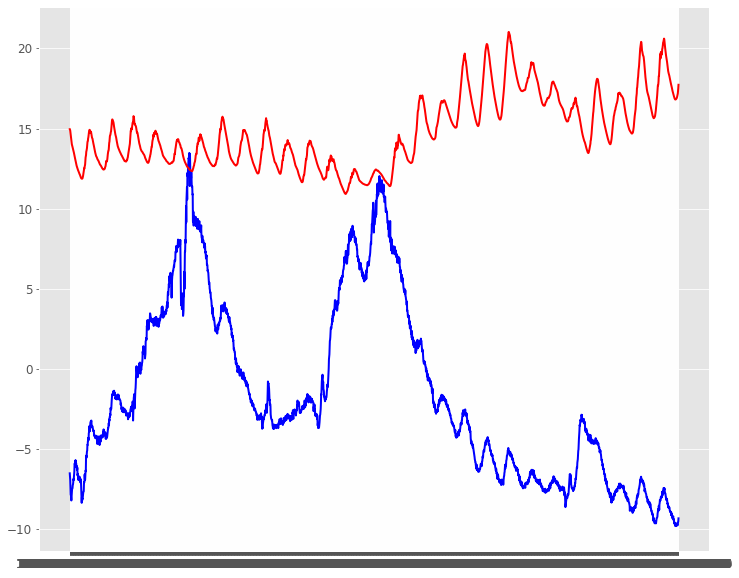

In [118]:
i = '46'
plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['dH']*200, color = 'blue')
plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['temperature_stream'], color = 'red')
plt.show()

In [119]:
data[i]['pression']['dates'].is_monotonic_increasing

False

In [120]:
data[i]['pression2'].drop(columns='dH').to_csv('/Users/marcoul/Desktop/Mines_2A/Molonari/MOLONARI_projet_3-/inversion/data_cleanded' + '/point0' + data[i]['numero'] + '_capteur_riviere_cleaned.csv', index=False)

In [121]:
data[i]['temperature2'].to_csv('/Users/marcoul/Desktop/Mines_2A/Molonari/MOLONARI_projet_3-/inversion/data_cleanded' + '/point0' + data[i]['numero'] + '_capteur_ZH_cleaned.csv', index=False)

# Traitement des signaux de temperature et pression

### Evaluer la correlation entre les signaux pour chaque point

In [76]:

# Générer deux signaux synthétiques de température et de pression (ou charger vos données réelles)
# Assurez-vous que les signaux ont la même longueur
for point in data.values():
    print(f"point {point['numero']}")
    temperature_signal = point['pression2']['temperature_stream']
    pressure_signal = point['pression2']['dH']


    # Calculer la corrélation entre les deux signaux
    correlation = np.corrcoef(temperature_signal, pressure_signal)[0, 1]

    # Afficher la corrélation
    print(f"Corrélation entre température et pression : {correlation:.2f}")

    # Interprétation de la corrélation
    if correlation > 0:
        print("Corrélation positive : Les signaux sont corrélés positivement.")
    elif correlation < 0:
        print("Corrélation négative : Les signaux sont corrélés négativement.")
    else:
        print("Corrélation nulle : Aucune corrélation linéaire entre les signaux.")

    # Vous pouvez également calculer le coefficient de détermination (R²) pour évaluer la force de la corrélation.
    r_squared = correlation**2
    print(f"Coefficient de détermination (R²) : {r_squared:.2f}")  




point 35
Corrélation entre température et pression : -0.10
Corrélation négative : Les signaux sont corrélés négativement.
Coefficient de détermination (R²) : 0.01
point 14
Corrélation entre température et pression : 0.44
Corrélation positive : Les signaux sont corrélés positivement.
Coefficient de détermination (R²) : 0.20
point 15
Corrélation entre température et pression : -0.28
Corrélation négative : Les signaux sont corrélés négativement.
Coefficient de détermination (R²) : 0.08
point 47
Corrélation entre température et pression : 0.64
Corrélation positive : Les signaux sont corrélés positivement.
Coefficient de détermination (R²) : 0.40
point 13
Corrélation entre température et pression : -0.95
Corrélation négative : Les signaux sont corrélés négativement.
Coefficient de détermination (R²) : 0.89
point 36
Corrélation entre température et pression : 0.40
Corrélation positive : Les signaux sont corrélés positivement.
Coefficient de détermination (R²) : 0.16
point 46
Corrélation entr

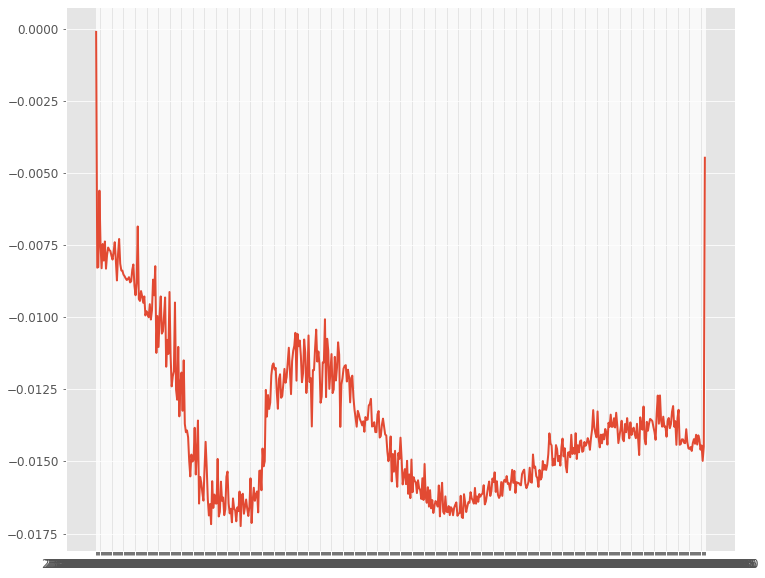

In [77]:
plt.plot(data['14']['pression2']['dates'], data['14']['pression2']['dH'])

In [78]:
data['14']['pression2'].drop(data['14']['pression2'].head(1).index,inplace=True)
data['14']['pression2'].drop(data['14']['pression2'].tail(1).index,inplace=True)

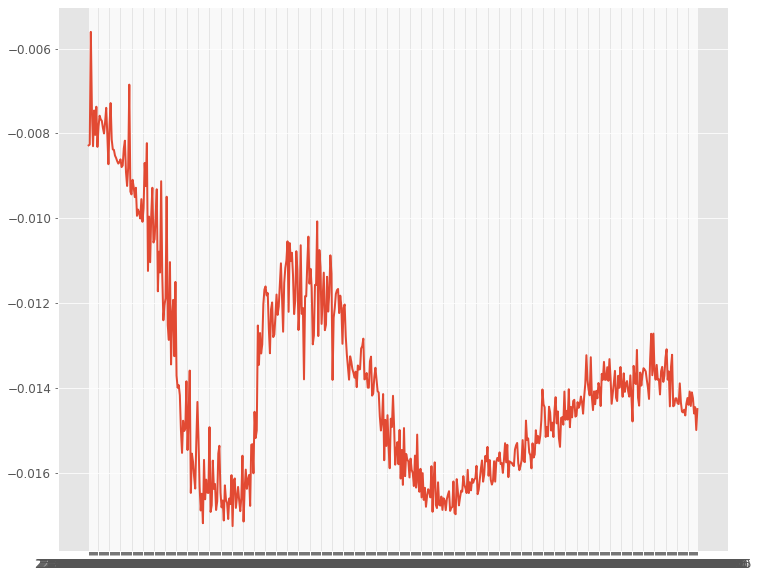

In [79]:
plt.plot(data['14']['pression2']['dates'], data['14']['pression2']['dH'])

In [80]:
def filter_signal(th):
    f_s = fft_filter(th)
    return np.real(np.fft.ifft(f_s))
def fft_filter(perc):
    fft_signal = np.fft.fft(signal)
    fft_abs = np.abs(fft_signal)
    th=perc*(2*fft_abs[0:int(len(signal)/2.)]/len(new_Xph)).max()
    fft_tof=fft_signal.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(new_Xph)
    fft_tof[fft_tof_abs<=th]=0
    return fft_tof
def fft_filter_amp(th):
    fft = np.fft.fft(signal)
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(new_Xph)
    fft_tof_abs[fft_tof_abs<=th]=0
    return fft_tof_abs[0:int(len(fft_tof_abs)/2.)]

In [81]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import scipy 
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [82]:
dH = data[i]['pression2']['dH']*150
T = data[i]['pression2']['temperature_stream']

In [83]:
np.corrcoef(dH,T)

array([[1.        , 0.41381175],
       [0.41381175, 1.        ]])

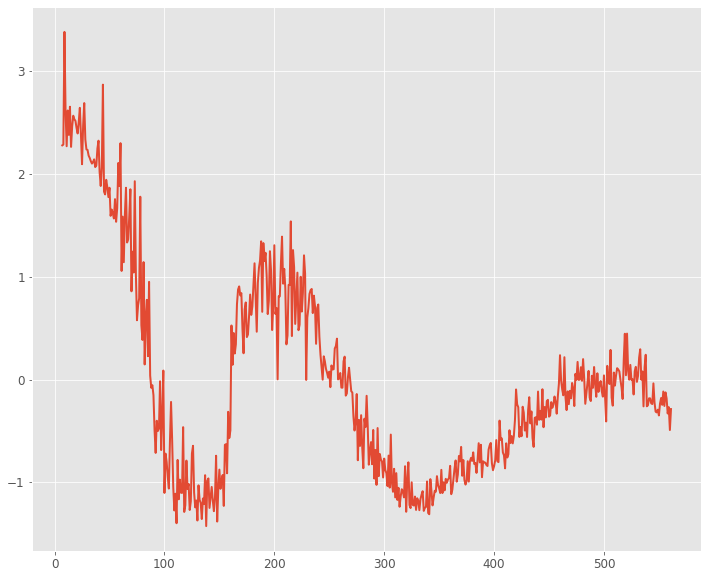

In [84]:
dH_std = (dH - np.mean(dH)) / np.std(dH)
plt.plot(dH_std)

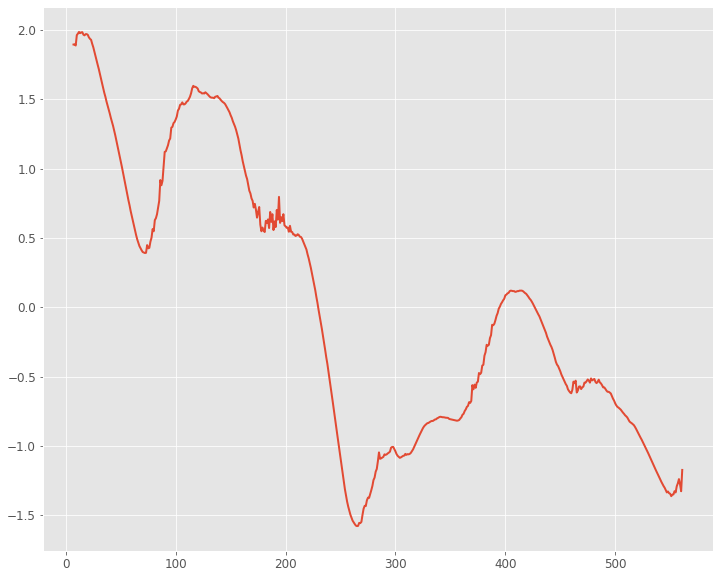

In [85]:
T_std = (T - np.mean(T)) / np.std(T)
plt.plot(T_std)

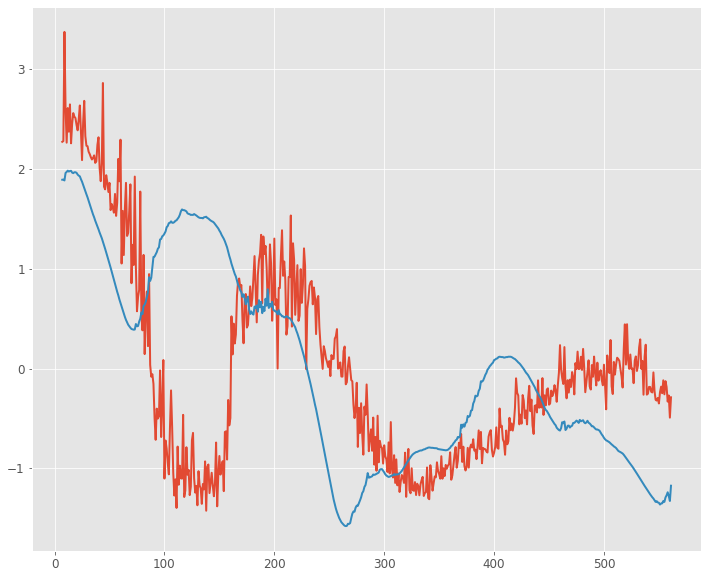

In [86]:
plt.plot(dH_std)
plt.plot(T_std)

In [87]:

from sklearn.decomposition import FastICA

signals = np.vstack((dH_std, T_std))

ica = FastICA(n_components=2, whiten='unit-variance')
decorrelated_signals = ica.fit_transform(signals.T)
A = ica.mixing_
S = decorrelated_signals.dot(A.T)

indice_dH_decorr = np.argmax(np.array([np.abs(np.corrcoef(dH_std, decorrelated_signals[:,0])[0,1]),np.abs(np.corrcoef(dH_std, decorrelated_signals[:,1])[0,1])]))
sign_dh_decorr = np.sign(np.corrcoef(dH_std, decorrelated_signals[:,indice_dH_decorr])[0,1])

dH_decorr = sign_dh_decorr*decorrelated_signals[:,indice_dH_decorr]
dH_decorr_std = (dH_decorr - np.mean(dH_decorr)) / np.std(dH_decorr)

dH_cleaned = dH_decorr_std*np.std(dH) + np.mean(dH)

/Users/marcoul/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


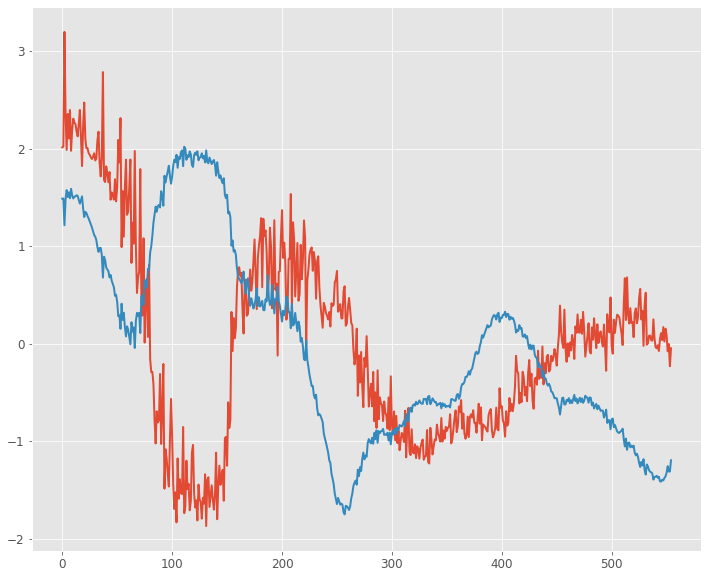

[[ 1.00000000e+00 -1.92038577e-16]
 [-1.92038577e-16  1.00000000e+00]]


In [88]:
decorr_std_signals = (decorrelated_signals - np.mean(decorrelated_signals, axis=0))/np.std(decorrelated_signals, axis=0)
plt.plot(decorr_std_signals)
#plt.plot(dH_std)
#plt.plot(-T_std)
#plt.legend(['dH decorr','T decorr','dH','T'])
plt.show()

print(np.corrcoef(decorr_std_signals[:,0],decorr_std_signals[:,1]))

In [89]:
np.corrcoef(dH_cleaned, T)

array([[1.        , 0.21963127],
       [0.21963127, 1.        ]])

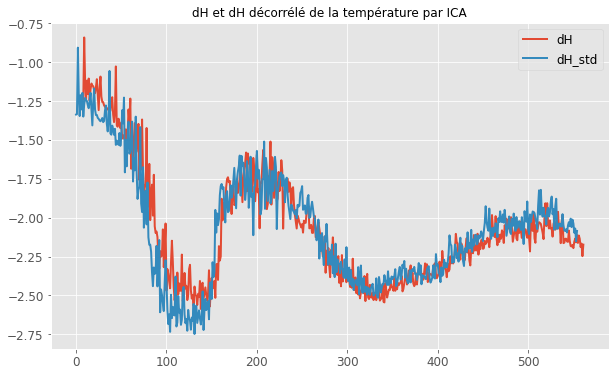

In [90]:
fig = plt.figure(figsize=(10, 6))
plt.plot(dH)
plt.plot(dH_cleaned)
plt.legend(["dH","dH_std"])
plt.title("dH et dH décorrélé de la température par ICA")
plt.show()